# Data Exploration and Analysis
on TCGA (The Cancer Genome Atlas) and CCLE (Cancer Cell Line Encyclopedia)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pacmap import PaCMAP
import matplotlib.colors as mcolors
from src.raw_data_loader import *
from src.data_visualization import combined_data_pacmap

## Load the data
in the same directory there has to be a folder named data with filtered_17713_gene_names.csv, CCLE_expression_full.csv and EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena in it.

In [2]:
ccle, tcga, ccle_metadata, tcga_metadata = ccle_tcga_loader()

fast loading of ccle and tcga and metadata as tcga.csv and ccle.csv are already present
load ccle
load tcga
load ccle_metadata
load tcga_metadata


In [3]:
ccle_metadata["primary_disease"].unique()

array(['Ovarian Cancer', 'Leukemia', 'Colon/Colorectal Cancer',
       'Skin Cancer', 'Bladder Cancer', 'Lung Cancer', 'Kidney Cancer',
       'Breast Cancer', 'Pancreatic Cancer', 'Myeloma', 'Brain Cancer',
       'Sarcoma', 'Lymphoma', 'Bone Cancer', 'Non-Cancerous',
       'Thyroid Cancer', 'Neuroblastoma', 'Prostate Cancer', 'Rhabdoid',
       'Gastric Cancer', 'Unknown', 'Gallbladder Cancer',
       'Endometrial/Uterine Cancer', 'Head and Neck Cancer',
       'Bile Duct Cancer', 'Esophageal Cancer', 'Liver Cancer',
       'Cervical Cancer', 'Eye Cancer', 'Adrenal Cancer', 'Liposarcoma',
       'Embryonal Cancer', 'Teratoma'], dtype=object)

In [4]:
tcga_metadata["cgc_case_primary_site"].unique()

array(['Brain', 'Liver', 'Cervix', 'Lung', 'Blood', 'Breast', 'Skin',
       'Pancreas', 'Esophagus', 'Mesenchymal', 'Kidney', 'Prostate',
       'Stomach', 'Head and Neck', 'Thymus', 'Colorectal', 'Bladder',
       'Thyroid', 'Mesothelium', 'Ovary', 'Testis', 'Uterus', 'Eye',
       'Nervous System', 'Lymph Nodes', 'Bile Duct', 'Adrenal Gland', nan],
      dtype=object)

In [5]:
ccle_metadata.columns

Index(['cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias',
       'COSMICID', 'sex', 'source', 'RRID', 'WTSI_Master_Cell_ID',
       'sample_collection_site', 'primary_or_metastasis', 'primary_disease',
       'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments',
       'lineage', 'lineage_subtype', 'lineage_sub_subtype',
       'lineage_molecular_subtype', 'default_growth_pattern',
       'model_manipulation', 'model_manipulation_details', 'patient_id',
       'parent_depmap_id', 'Cellosaurus_NCIt_disease', 'Cellosaurus_NCIt_id',
       'Cellosaurus_issues'],
      dtype='object')

In [4]:
# Define mapping of cancer types such that ccle adopts the naming scheme of tcga. IMPORTANT: this mapping is not 100% correct
mapping = {
    'Ovarian Cancer': 'Ovary',
    'Leukemia': 'Blood',
    'Colon/Colorectal Cancer': 'Colorectal',
    'Skin Cancer': 'Skin',
    'Bladder Cancer': 'Bladder',
    'Lung Cancer': 'Lung',
    'Kidney Cancer': 'Kidney',
    'Breast Cancer': 'Breast',
    'Pancreatic Cancer': 'Pancreas',
    'Myeloma': 'Bone Marrow',
    'Brain Cancer': 'Brain',
    'Sarcoma': 'Mesenchymal',
    'Lymphoma': 'Lymph Nodes',
    'Bone Cancer': 'Bone',
    'Non-Cancerous': 'Non-Cancerous',  # No direct match
    'Thyroid Cancer': 'Thyroid',
    'Neuroblastoma': 'Nervous System',
    'Prostate Cancer': 'Prostate',
    'Rhabdoid': 'Rhabdoid',  # No direct match
    'Gastric Cancer': 'Stomach',
    'Unknown': 'Unknown',  # No direct match, NaNs in tcga are changed to 'Unknown'
    'Gallbladder Cancer': 'Gallbladder Cancer',  # No direct match
    'Endometrial/Uterine Cancer': 'Uterus',
    'Head and Neck Cancer': 'Head and Neck',
    'Bile Duct Cancer': 'Bile Duct',
    'Esophageal Cancer': 'Esophagus',
    'Liver Cancer': 'Liver',
    'Cervical Cancer': 'Cervix',
    'Eye Cancer': 'Eye',
    'Adrenal Cancer': 'Adrenal Gland',
    'Liposarcoma': 'Liposarcoma',  # No direct match
    'Embryonal Cancer': 'Embryonal Cancer',  # No direct match
    'Teratoma': 'Teratoma'  # No direct match
}


In [5]:
tcga_combined = tcga.copy()

# label all entries as tcga
tcga_combined["dataset"] = np.full_like(tcga_combined.index, "tcga")

# assign the gender
tcga_combined["gender"] = tcga_metadata["gdc_cases.demographic.gender"]

# age
tcga_combined["age"] = tcga_metadata["cgc_case_age_at_diagnosis"]

# disease
tcga_combined["primary_disease"] = tcga_metadata['cgc_case_primary_site'].fillna('Unknown')

In [6]:
ccle_combined = ccle.copy()

# label all entries as ccle
ccle_combined["dataset"] = np.full_like(ccle_combined.index, "ccle")

# assign the gender
ccle_combined["gender"] = ccle_metadata["sex"].str.lower()

# age
ccle_combined["age"] = pd.to_numeric(ccle_metadata["age"], errors="coerce")

# disease
ccle_combined["primary_disease"] = ccle_metadata['primary_disease'].map(mapping)

In [9]:
tcga_metadata["gdc_cases.project.project_id"].unique()

array(['TCGA-LGG', 'TCGA-LIHC', 'TCGA-CESC', 'TCGA-LUAD', 'TCGA-LAML',
       'TCGA-BRCA', 'TCGA-SKCM', 'TCGA-PAAD', 'TCGA-ESCA', 'TCGA-SARC',
       'TCGA-KIRP', 'TCGA-PRAD', 'TCGA-STAD', 'TCGA-HNSC', 'TCGA-GBM',
       'TCGA-KIRC', 'TCGA-THYM', 'TCGA-COAD', 'TCGA-BLCA', 'TCGA-LUSC',
       'TCGA-THCA', 'TCGA-MESO', 'TCGA-READ', 'TCGA-OV', 'TCGA-TGCT',
       'TCGA-UCEC', 'TCGA-UVM', 'TCGA-UCS', 'TCGA-PCPG', 'TCGA-KICH',
       'TCGA-DLBC', 'TCGA-CHOL', 'TCGA-ACC'], dtype=object)

In [10]:
[print(col, np.unique(ccle_metadata[col].astype(str))) for col in ccle_metadata.columns]

cell_line_name ['1273/99' '143B' '170-MG-BA' ... 'mel-202' 'nan' 'no.10']
stripped_cell_line_name ['127399' '143B' '170MGBA' ... 'YUHOIN0650' 'ZR751' 'ZR7530']
CCLE_Name ['127399_SOFT_TISSUE' '143B_BONE' '170MGBA_CENTRAL_NERVOUS_SYSTEM' ...
 'ZR751_BREAST' 'ZR7530_BREAST' 'nan']
alias ['22-RV1' 'A101D, Hs 294.T' 'A375 ER-2' 'A375 RMR' 'A375 RMR SCH 0.25'
 'CACO2, CaCo-2' 'CADO-ES-1' 'CB-AGPN' 'CHL-1' 'COG-E-352' 'COR-L23/CPR'
 'D283' 'D341MED' 'DL-40' 'EHGB2' 'G292CLONEA141B1, G-292 clone A141B1'
 'GR-M' 'H1184' 'H1963' 'H209' 'H2171' 'H292' 'HCC827 GR5' 'HNT-34'
 'HS-860, HS860' 'HT144_Dab' 'HT144_Dab_Tram' 'HTB-48' 'HTT144_Dab_Rox'
 'HeLa' 'Hs 600.T' 'Hs 822.T' 'ICC13' 'INA-6' 'IOMM-LEE' 'IST-MES-2'
 'JR-1' 'KHYG1, KHYG-1' 'KKU-M213' 'KOSC-2' 'LC-1/sq-SF' 'LC-1F' 'LN-235'
 'LN-382' 'LNCAPCLONEFGC, LN-Cap-cloneFGC, LNCaP clone FGC' 'M160113'
 'MM 253, MM-253' 'MM 485, MM-485' 'MPNST-724' 'MUTZ3' 'MV-4-11'
 'NALM-16, Nalm-16' 'NCI-H2077' 'NCI-H2882' 'NCI-H2887' 'NO 36, NO-36'
 'NZM 3, 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [11]:
ccle_metadata["source"]

DepMap_ID
ACH-000001                                     ATCC
ACH-000002                                     ATCC
ACH-000003                                     ATCC
ACH-000004                                     DSMZ
ACH-000005                                     ATCC
                              ...                  
ACH-002785                             Academic lab
ACH-002800                             Academic lab
ACH-002834                                      NaN
ACH-002847                                 Academic
ACH-002926    QIMRB Berghofer (via CRUK Manchester)
Name: source, Length: 1406, dtype: object

In [12]:
tcga_combined

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,dataset,gender,age,primary_disease
TCGA-02-0047-01,6.98,0.00,15.05,5.40,5.22,1.16,8.87,8.92,0.00,0.00,...,10.12,0.69,10.24,11.92,10.45,9.24,tcga,male,78.0,Brain
TCGA-02-0055-01,8.62,0.00,15.39,1.42,8.93,0.64,9.22,8.31,0.64,0.00,...,9.25,2.60,9.85,13.49,9.25,9.49,tcga,female,62.0,Brain
TCGA-02-2483-01,8.09,0.00,14.36,1.82,6.46,0.00,10.11,8.95,0.00,0.00,...,9.76,5.50,10.24,12.31,9.70,9.46,tcga,male,43.0,Brain
TCGA-02-2485-01,6.41,0.00,12.93,7.73,7.29,0.56,9.99,8.25,0.56,0.00,...,10.40,0.00,10.06,12.31,10.16,9.45,tcga,male,53.0,Brain
TCGA-02-2486-01,6.77,0.00,15.32,6.71,5.49,0.00,9.46,8.62,0.00,0.00,...,9.35,0.00,9.43,12.93,9.30,9.05,tcga,male,64.0,Brain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CG-01,14.19,11.22,13.37,0.00,7.88,0.00,9.78,7.54,14.26,0.00,...,9.74,6.50,11.00,10.94,9.30,9.28,tcga,male,55.0,Liver
TCGA-ZT-A8OM-01,11.47,0.00,13.47,0.00,7.99,1.98,10.92,9.21,2.57,0.99,...,9.58,2.57,8.10,13.17,10.07,8.25,tcga,female,73.0,Thymus
TCGA-ZU-A8S4-01,7.42,6.68,13.26,0.00,9.30,1.58,9.55,9.19,8.84,0.00,...,9.27,0.58,9.51,13.37,9.97,9.32,tcga,male,51.0,Bile Duct
TCGA-ZU-A8S4-11,16.71,11.28,16.78,0.00,5.36,2.68,9.37,7.60,13.21,0.00,...,9.83,5.64,11.37,11.00,9.49,8.95,tcga,male,51.0,Bile Duct


In [13]:
ccle_combined

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,dataset,gender,age,primary_disease
ACH-000001,3.116032,0.056584,0.226509,0.111031,1.035624,0.176323,5.700440,4.144046,0.790772,0.014355,...,4.700994,3.282440,2.797013,6.821455,3.010780,4.381975,ccle,female,60.0,Ovary
ACH-000002,1.395063,0.000000,0.275007,0.111031,0.137504,0.000000,5.078951,1.948601,0.000000,0.000000,...,3.925050,0.000000,1.070389,5.963474,2.169925,3.255501,ccle,female,36.0,Blood
ACH-000003,1.400538,4.305241,0.321928,0.150560,4.219556,0.097611,5.195348,3.962549,1.687061,0.000000,...,2.851999,0.704872,2.316146,7.302867,2.659925,2.748461,ccle,male,72.0,Colorectal
ACH-000004,4.178715,0.000000,0.214125,0.344828,0.097611,0.000000,6.336819,3.231125,0.000000,0.000000,...,3.619413,0.014355,2.032101,7.002252,3.444932,4.910733,ccle,male,30.0,Blood
ACH-000005,4.003602,0.014355,0.137504,0.014355,0.028569,0.000000,6.337176,3.781360,0.000000,0.000000,...,3.763412,0.014355,2.761285,6.826421,3.524816,5.592457,ccle,male,30.0,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002785,1.967169,0.000000,2.198494,0.000000,1.490570,0.000000,5.300490,4.314697,0.042644,0.000000,...,2.918386,0.014355,4.173127,6.560256,2.969012,5.276869,ccle,female,42.0,Unknown
ACH-002800,3.847997,0.000000,5.899901,0.321928,3.206331,0.000000,5.831877,3.822730,1.443607,0.000000,...,2.639232,0.622930,3.084064,6.596935,3.177918,4.847997,ccle,male,54.0,Unknown
ACH-002834,1.819668,0.014355,0.014355,0.201634,2.912650,0.028569,5.646451,4.547820,0.000000,0.000000,...,2.904966,1.400538,2.568032,6.953498,3.087463,4.226509,ccle,female,NaN,Bone
ACH-002847,2.990955,0.000000,7.608440,0.014355,0.584963,0.000000,5.104337,4.228819,0.000000,0.000000,...,2.845992,1.480265,2.748461,7.432041,2.903038,4.660495,ccle,female,59.0,Unknown


In [7]:
data = pd.concat([tcga_combined, ccle_combined], axis=0)
data

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,dataset,gender,age,primary_disease
TCGA-02-0047-01,6.980000,0.000000,15.050000,5.400000,5.220000,1.160000,8.870000,8.920000,0.000000,0.0,...,10.120000,0.690000,10.240000,11.920000,10.450000,9.240000,tcga,male,78.0,Brain
TCGA-02-0055-01,8.620000,0.000000,15.390000,1.420000,8.930000,0.640000,9.220000,8.310000,0.640000,0.0,...,9.250000,2.600000,9.850000,13.490000,9.250000,9.490000,tcga,female,62.0,Brain
TCGA-02-2483-01,8.090000,0.000000,14.360000,1.820000,6.460000,0.000000,10.110000,8.950000,0.000000,0.0,...,9.760000,5.500000,10.240000,12.310000,9.700000,9.460000,tcga,male,43.0,Brain
TCGA-02-2485-01,6.410000,0.000000,12.930000,7.730000,7.290000,0.560000,9.990000,8.250000,0.560000,0.0,...,10.400000,0.000000,10.060000,12.310000,10.160000,9.450000,tcga,male,53.0,Brain
TCGA-02-2486-01,6.770000,0.000000,15.320000,6.710000,5.490000,0.000000,9.460000,8.620000,0.000000,0.0,...,9.350000,0.000000,9.430000,12.930000,9.300000,9.050000,tcga,male,64.0,Brain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002785,1.967169,0.000000,2.198494,0.000000,1.490570,0.000000,5.300490,4.314697,0.042644,0.0,...,2.918386,0.014355,4.173127,6.560256,2.969012,5.276869,ccle,female,42.0,Unknown
ACH-002800,3.847997,0.000000,5.899901,0.321928,3.206331,0.000000,5.831877,3.822730,1.443607,0.0,...,2.639232,0.622930,3.084064,6.596935,3.177918,4.847997,ccle,male,54.0,Unknown
ACH-002834,1.819668,0.014355,0.014355,0.201634,2.912650,0.028569,5.646451,4.547820,0.000000,0.0,...,2.904966,1.400538,2.568032,6.953498,3.087463,4.226509,ccle,female,NaN,Bone
ACH-002847,2.990955,0.000000,7.608440,0.014355,0.584963,0.000000,5.104337,4.228819,0.000000,0.0,...,2.845992,1.480265,2.748461,7.432041,2.903038,4.660495,ccle,female,59.0,Unknown


In [8]:
data.to_csv("data/data.csv")

comments regarding tcga and ccle: 
tcga data has 11069 rows. On the website they write once it has 11069 entries and once 11060. I have currently not found any metadata regarding which samples are cancer and which not.

ccle has metadata regarding which samples belong to which cell line. Also, ccle has fewer genes as some were _not_ present in this dataset.

## Basic Data Analysis

Text(0.5, 1.0, 'Genes in Dataset')

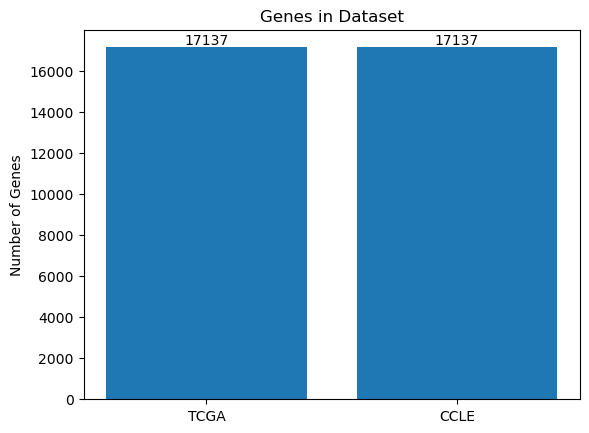

In [15]:

tcga_genes = tcga.shape[1]
ccle_genes = ccle.shape[1]

# Create bar plot
plt.bar(x=("TCGA", "CCLE"), height=(tcga_genes, ccle_genes))

# Add values to the bars
for i, value in enumerate((tcga_genes, ccle_genes)):
    plt.text(i, value + 0.05, str(value), ha='center', va='bottom')

# Add labels and title
plt.ylabel('Number of Genes')
plt.title('Genes in Dataset')

Text(0.5, 1.0, 'Samples for each dataset')

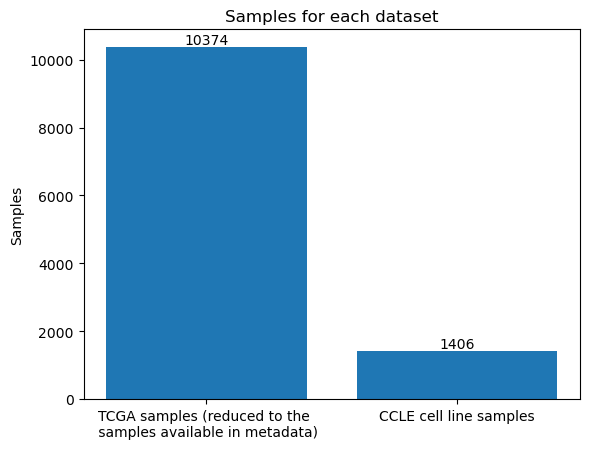

In [16]:
fig, ax1 = plt.subplots()

tcga_samples = tcga.shape[0]
ccle_cell_lines = ccle.shape[0]

# Create bar plot
plt.bar(x=("TCGA samples (reduced to the \n samples available in metadata)", "CCLE cell line samples"), height=(tcga_samples, ccle_cell_lines))

# Add values to the bars
for i, value in enumerate((tcga_samples, ccle_cell_lines)):
    plt.text(i, value + 0.05, str(value), ha='center', va='bottom')

# Add labels and title
plt.ylabel('Samples')
plt.title('Samples for each dataset')

## Data Analysis of CCLE


In [17]:
ccle_metadata

,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,sample_collection_site,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000001,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,Female,ATCC,CVCL_0465,2201.0,ascites,...,high_grade_serous,NaN,2D: adherent,NaN,NaN,PT-gj46wT,NaN,High grade ovarian serous adenocarcinoma,C105555,NaN
ACH-000002,HL-60,HL60,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,905938.0,Female,ATCC,CVCL_0002,55.0,haematopoietic_and_lymphoid_tissue,...,M3,NaN,2D: suspension,NaN,NaN,PT-5qa3uk,NaN,Adult acute myeloid leukemia,C9154,NaN
ACH-000003,CACO2,CACO2,CACO2_LARGE_INTESTINE,"CACO2, CaCo-2",NaN,Male,ATCC,CVCL_0025,NaN,Colon,...,NaN,NaN,NaN,NaN,NaN,PT-puKIyc,NaN,Colon adenocarcinoma,C4349,NaN
ACH-000004,HEL,HEL,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,907053.0,Male,DSMZ,CVCL_0001,783.0,haematopoietic_and_lymphoid_tissue,...,M6,NaN,2D: suspension,NaN,NaN,PT-q4K2cp,NaN,Erythroleukemia,C7152,NaN
ACH-000005,HEL 92.1.7,HEL9217,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Male,ATCC,CVCL_2481,NaN,bone_marrow,...,M6,NaN,2D: suspension,NaN,NaN,PT-q4K2cp,ACH-000004,Erythroleukemia,C7152,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002785,NCC-LMS1-C1,NCCLMS1C1,NaN,NaN,NaN,Female,Academic lab,CVCL_LK56,NaN,bone,...,NaN,NaN,2D: adherent,NaN,NaN,PT-6sPicj,NaN,Bone leiomyosarcoma,C7154,NaN
ACH-002800,NCC-MPNST2-C1,NCCMPNST2C1,NaN,NaN,NaN,Male,Academic lab,CVCL_YU13,NaN,NaN,...,NaN,NaN,2D: adherent,NaN,NaN,PT-WTpRkW,NaN,Malignant peripheral nerve sheath tumor,C3798,NaN
ACH-002834,PSS131R,PSS131R,PSS131R_Osteosarcoma,NaN,NaN,Female,NaN,NaN,NaN,bone,...,NaN,NaN,2D: adherent,NaN,NaN,PT-EcUHFc,NaN,NaN,NaN,NaN


In [18]:
ccle_metadata.columns
# most interesting: lineage lineage_subtype sex, ...

Index(['cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias',
       'COSMICID', 'sex', 'source', 'RRID', 'WTSI_Master_Cell_ID',
       'sample_collection_site', 'primary_or_metastasis', 'primary_disease',
       'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments',
       'lineage', 'lineage_subtype', 'lineage_sub_subtype',
       'lineage_molecular_subtype', 'default_growth_pattern',
       'model_manipulation', 'model_manipulation_details', 'patient_id',
       'parent_depmap_id', 'Cellosaurus_NCIt_disease', 'Cellosaurus_NCIt_id',
       'Cellosaurus_issues'],
      dtype='object')

In [19]:
print("Gene expression dataset entries: {}, unique dataset entries: {}".format(len(ccle), len(ccle.drop_duplicates())))
print("unique DepMap_IDs: {}".format(len(ccle_metadata.index.unique())))
print("unique cell lines: {}".format(len(ccle_metadata["cell_line_name"].unique())))
print("unique stripped lines: {}".format(len(ccle_metadata["stripped_cell_line_name"].unique())))

Gene expression dataset entries: 1406, unique dataset entries: 1406
unique DepMap_IDs: 1406
unique cell lines: 1359
unique stripped lines: 1406


cell_line_name is not a unique (contains NaN and one duplicate: U-251 MG), stripped_cell_line_name is. The two U-251 MG are from different tissues, have different stripped_cell_line_name and have different gene expression -> not real duplicates

/tmp/ipykernel_115110/1059548345.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset_transformed[:, 0], subset_transformed[:, 1], cmap="Spectral", label=id, s=0.6)


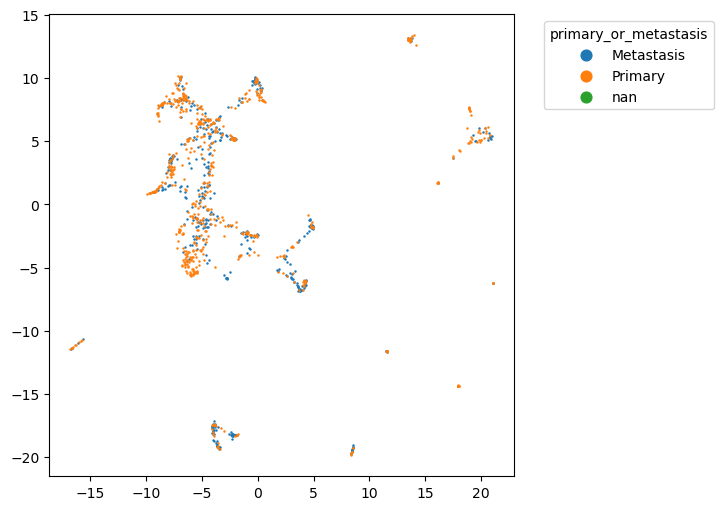

In [20]:

embedding = PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
ccle_transformed = embedding.fit_transform(ccle, init="pca")

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# select what should be color coded, e.g. sex, disease, ...
to_highlight = "primary_or_metastasis"
id_mapping = {id: i for i, id in enumerate(ccle_metadata[to_highlight].unique())}

for id, label in id_mapping.items():
    subset_indices = ccle_metadata[to_highlight] == id
    subset_transformed = ccle_transformed[subset_indices]
    ax.scatter(subset_transformed[:, 0], subset_transformed[:, 1], cmap="Spectral", label=id, s=0.6)

# Create a legend
if len(id_mapping) < 40:
    ax.legend(title=to_highlight, markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.title(to_highlight)

## Data Analysis of TCGA
TCGA contains NaN

/tmp/ipykernel_115110/686934635.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset_transformed[:, 0], subset_transformed[:, 1], cmap="Spectral", label=id, s=0.6)


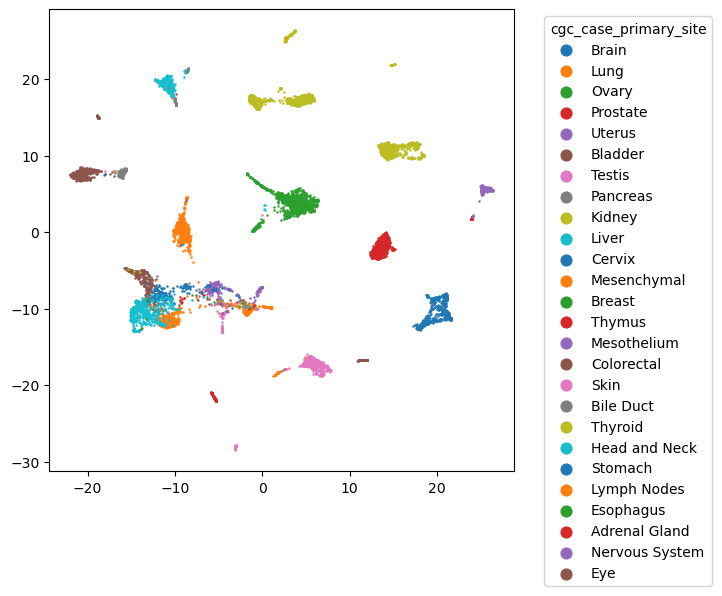

In [21]:
# Step 2: Drop rows with NaN values
tcga_clean = tcga.dropna()
tcga_metadata_clean = tcga_metadata.loc[tcga_clean.index]

embedding = PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
tcga_transformed = embedding.fit_transform(tcga_clean, init="pca")

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# select what should be color coded, e.g. sex, disease, ...
to_highlight = "cgc_case_primary_site"
id_mapping = {id: i for i, id in enumerate(tcga_metadata_clean[to_highlight].fillna('Unknown').unique())}

for id, label in id_mapping.items():
    subset_indices = tcga_metadata_clean[to_highlight].fillna('Unknown') == id
    subset_transformed = tcga_transformed[subset_indices]
    ax.scatter(subset_transformed[:, 0], subset_transformed[:, 1], cmap="Spectral", label=id, s=0.6)

# Create a legend
if len(id_mapping) < 40:
    ax.legend(title=to_highlight, markerscale=10, bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.title(to_highlight)

## Data Analysis on the combined dataset

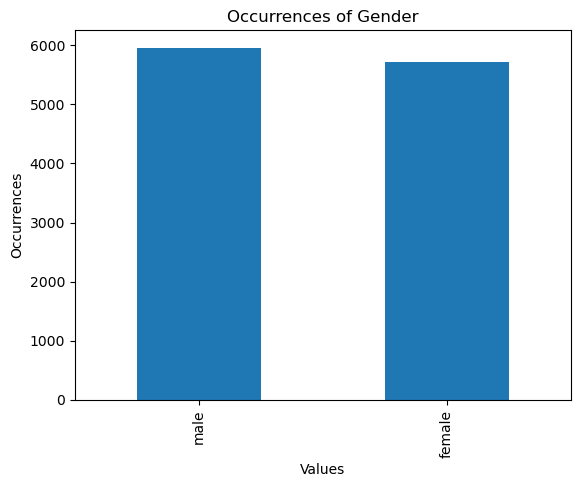

In [22]:
occurrences = data["gender"].value_counts()

# Plotting the occurrences as a bar plot
occurrences.plot(kind='bar')
plt.xlabel('Values')
plt.ylabel('Occurrences')
plt.title('Occurrences of Gender')
plt.show()

### pacmap plots on combined data
select labeling and how the data should be preprocessed

In [28]:
viz_preprocessing = {
    "only_most_variant": 5000, # can be a number or None
    "z_score_norm": "per_gene" # can be None, per_gene or per_sample
}

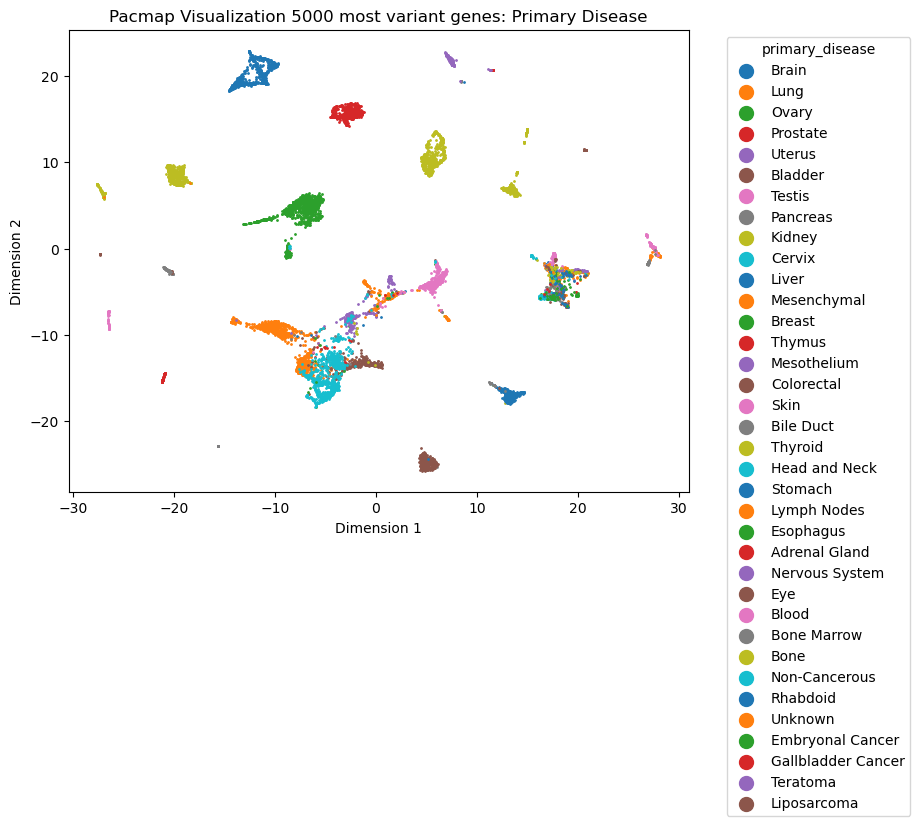

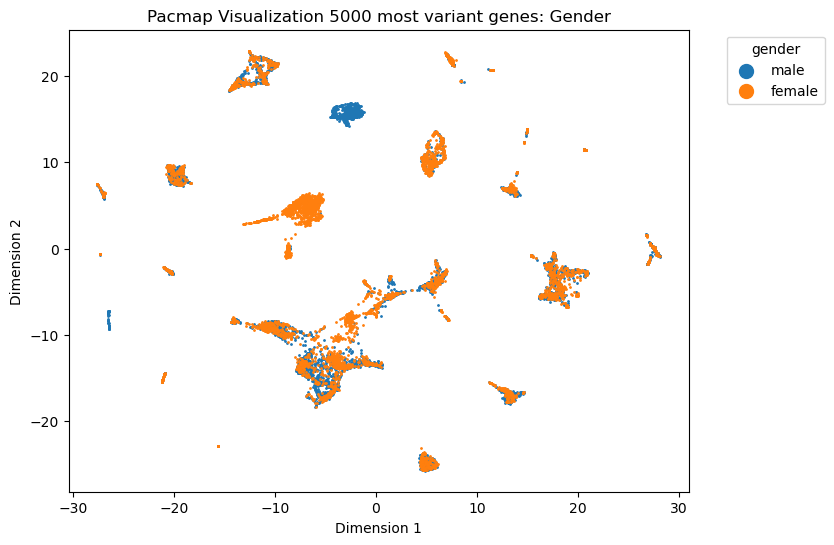

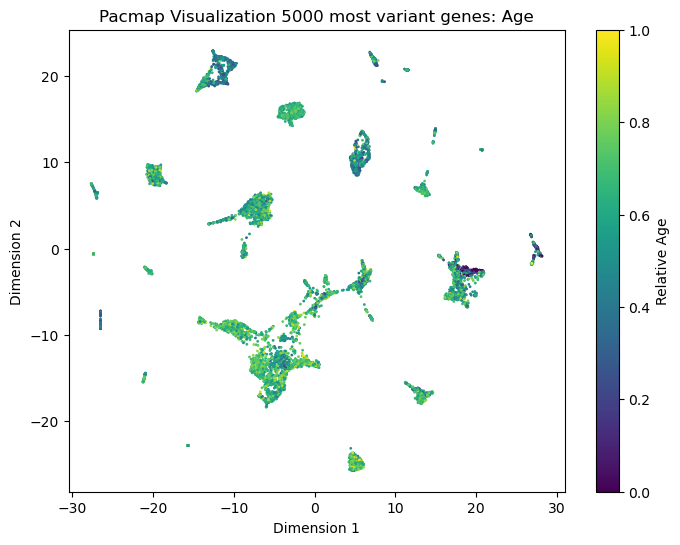

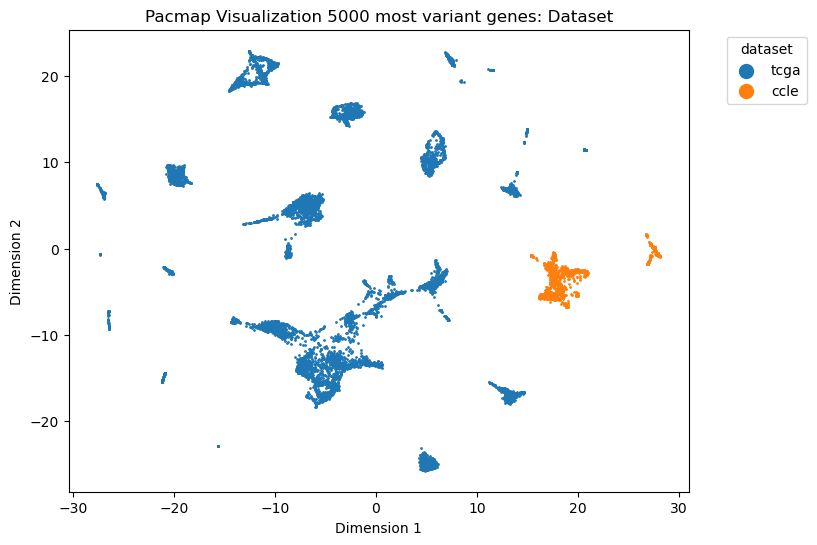

In [29]:
combined_data_pacmap(data, viz_preprocessing)